In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import pickle
import os

In [30]:
class LoanModelTrainer:
    def __init__(self, data_path: str, target: str = "loan_status"):
        self.data_path = data_path
        self.target = target
        self.df = None
        self.numeric_cols = []
        self.categorical_cols = []
        self.X_train = self.X_test = self.y_train = self.y_test = None
        self.rf_model = None
        self.xgb_model = None
        self.best_model = None

    def load_data(self):
        self.df = pd.read_csv(self.data_path)
        
        print("Missing Values:\n", self.df.isnull().sum())
        
        self.df = self.df.dropna()
        
        print("\nMissing Values after dropping:\n", self.df.isnull().sum())
        print("\nData loaded successfully!")

    def preprocess(self):
        self.numeric_cols = self.df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_cols = self.df.select_dtypes(include=['object', 'bool']).columns.tolist()
        
        if self.target in self.numeric_cols:
            self.numeric_cols.remove(self.target)

        le = LabelEncoder()
        for col in self.categorical_cols:
            self.df[col] = le.fit_transform(self.df[col])

        scaler = StandardScaler()
        self.df[self.numeric_cols] = scaler.fit_transform(self.df[self.numeric_cols])

        X = self.df.drop(columns=[self.target])
        y = self.df[self.target]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        print("\nPreprocessing complete.")
        print(f"Numeric features: {self.numeric_cols}")
        print(f"Categorical features: {self.categorical_cols}")

    def plot_features(self):
        if self.df is None:
            raise ValueError("Data is not loaded yet. Please run `load_data()` first.")

        if self.numeric_cols:
            print("\nPlotting numerical features...")
            self.df[self.numeric_cols].hist(figsize=(15, len(self.numeric_cols) * 2), bins=20, edgecolor='black')
            plt.suptitle('Numerical Feature Distributions', fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()
        else:
            print("No numerical features to plot.")

        if self.categorical_cols:
            print("\nPlotting categorical features...")
            plt.figure(figsize=(15, len(self.categorical_cols) * 3))
            for i, col in enumerate(self.categorical_cols):
                plt.subplot(len(self.categorical_cols), 1, i + 1)
                sns.countplot(data=self.df, x=col)
                plt.title(f'Count Plot of {col}')
                plt.xticks(rotation=45)
                plt.tight_layout()
            plt.suptitle('Categorical Feature Distributions', y=1.02, fontsize=16)
            plt.show()
        else:
            print("No categorical features to plot.")

        print("\nPlotting correlation matrix...")
        plt.figure(figsize=(12, 10))
        corr = self.df.corr(numeric_only=True)
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
        plt.title("Correlation Matrix", fontsize=16)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()

    def train_models(self):
        self.rf_model = RandomForestClassifier(random_state=42)
        self.rf_model.fit(self.X_train, self.y_train)

        self.xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        self.xgb_model.fit(self.X_train, self.y_train)

        print("\nModel training completed.")

    def evaluate_models(self):
        rf_pred = self.rf_model.predict(self.X_test)
        xgb_pred = self.xgb_model.predict(self.X_test)

        rf_acc = accuracy_score(self.y_test, rf_pred)
        xgb_acc = accuracy_score(self.y_test, xgb_pred)

        print("\n--- Evaluation Results ---")
        print(f"Random Forest Accuracy: {rf_acc:.4f}")
        print(f"XGBoost Accuracy     : {xgb_acc:.4f}")

        print("\nRandom Forest Classification Report:")
        print(classification_report(self.y_test, rf_pred))

        print("\nXGBoost Classification Report:")
        print(classification_report(self.y_test, xgb_pred))

        self.best_model = self.xgb_model if xgb_acc > rf_acc else self.rf_model
        print(f"\nBest model selected: {'XGBoost' if xgb_acc > rf_acc else 'Random Forest'}")

    def save_best_model(self, filename="best_loan_model.pkl"):
        with open(filename, "wb") as f:
            pickle.dump(self.best_model, f)
        print(f"\nBest model saved as '{filename}'")
    
    def run(self):
        self.load_data()
        self.preprocess()
        self.plot_features()
        self.train_models()
        self.evaluate_models()
        self.save_best_model()

Missing Values:
 person_age                           0
person_gender                        0
person_education                     0
person_income                     2250
person_emp_exp                       0
person_home_ownership                0
loan_amnt                            0
loan_intent                          0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
loan_status                          0
dtype: int64

Missing Values after dropping:
 person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length     

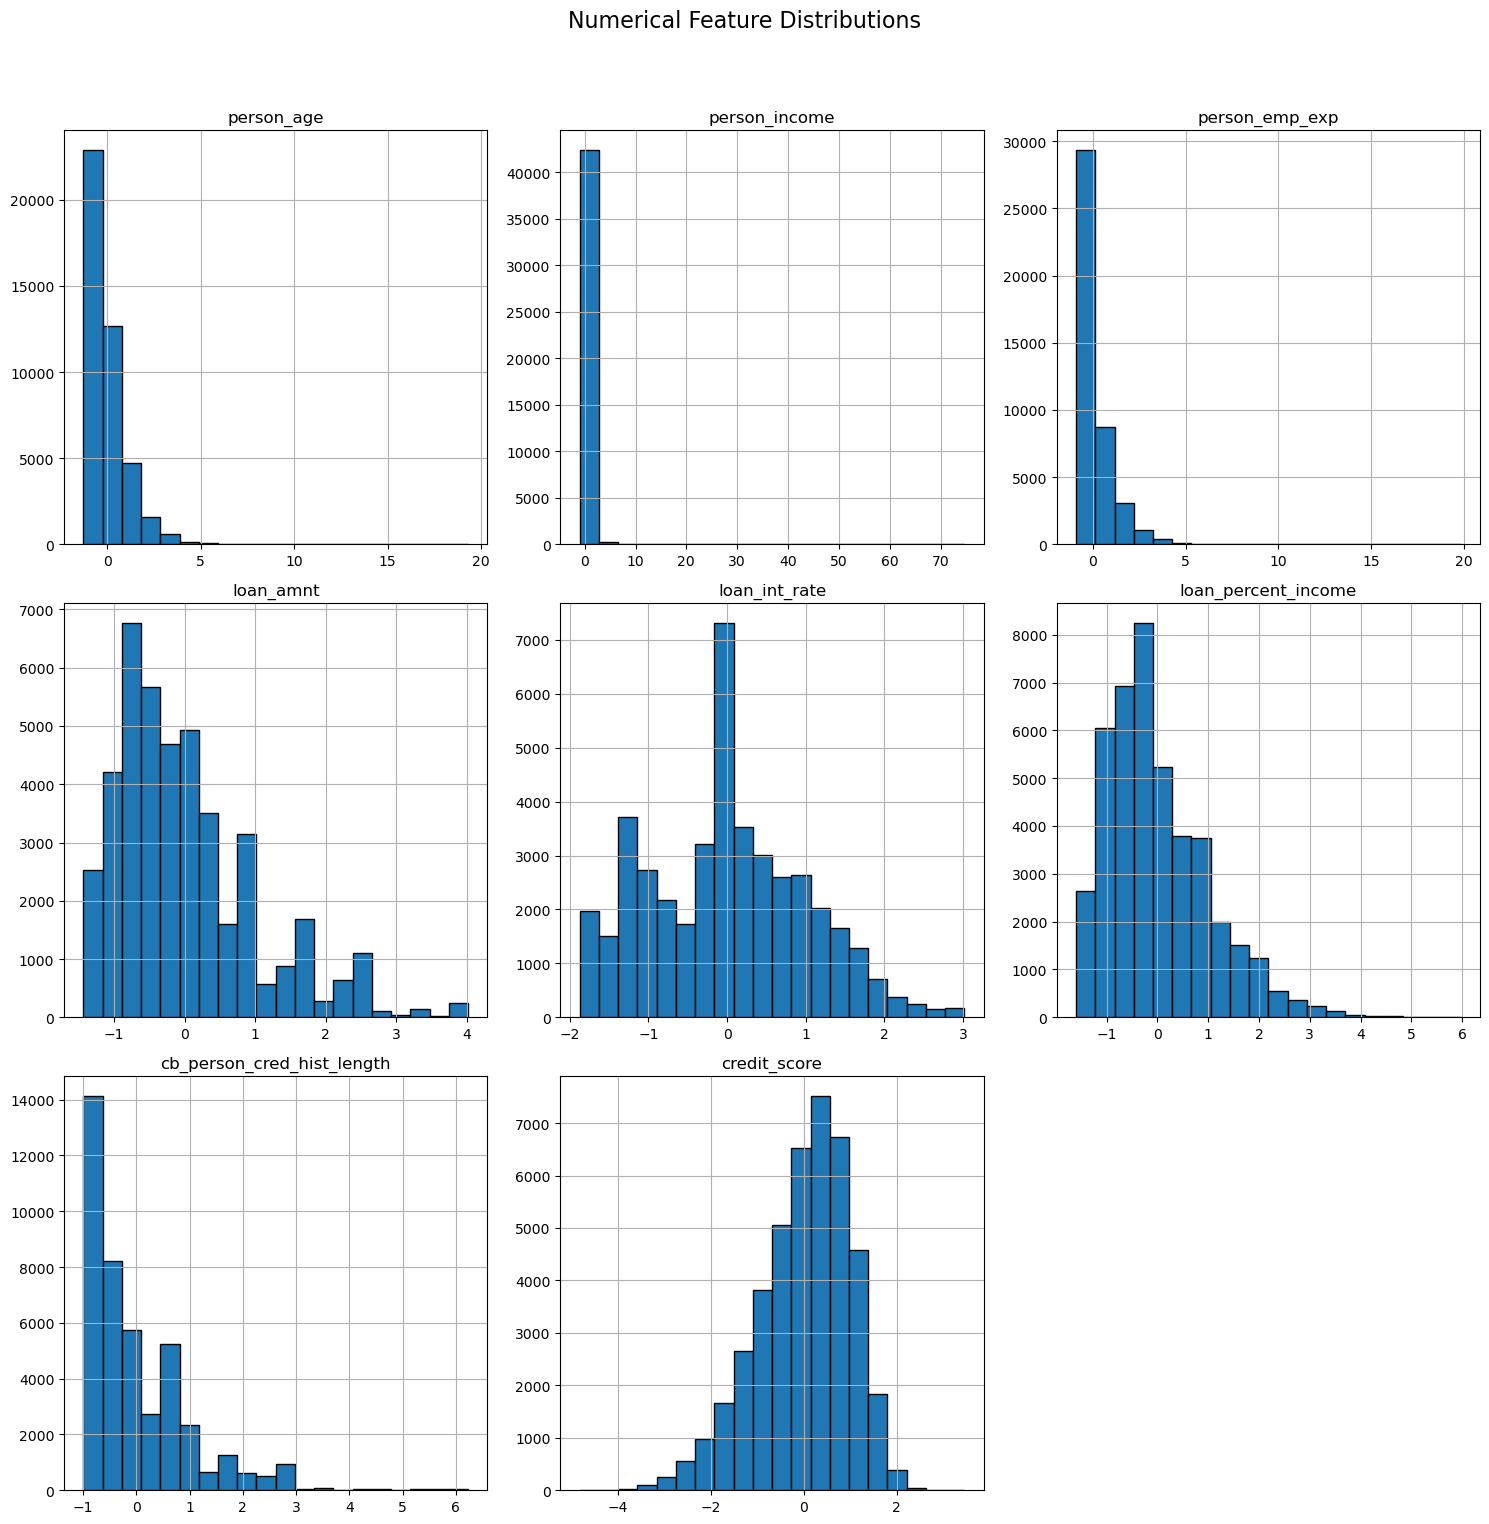


Plotting categorical features...


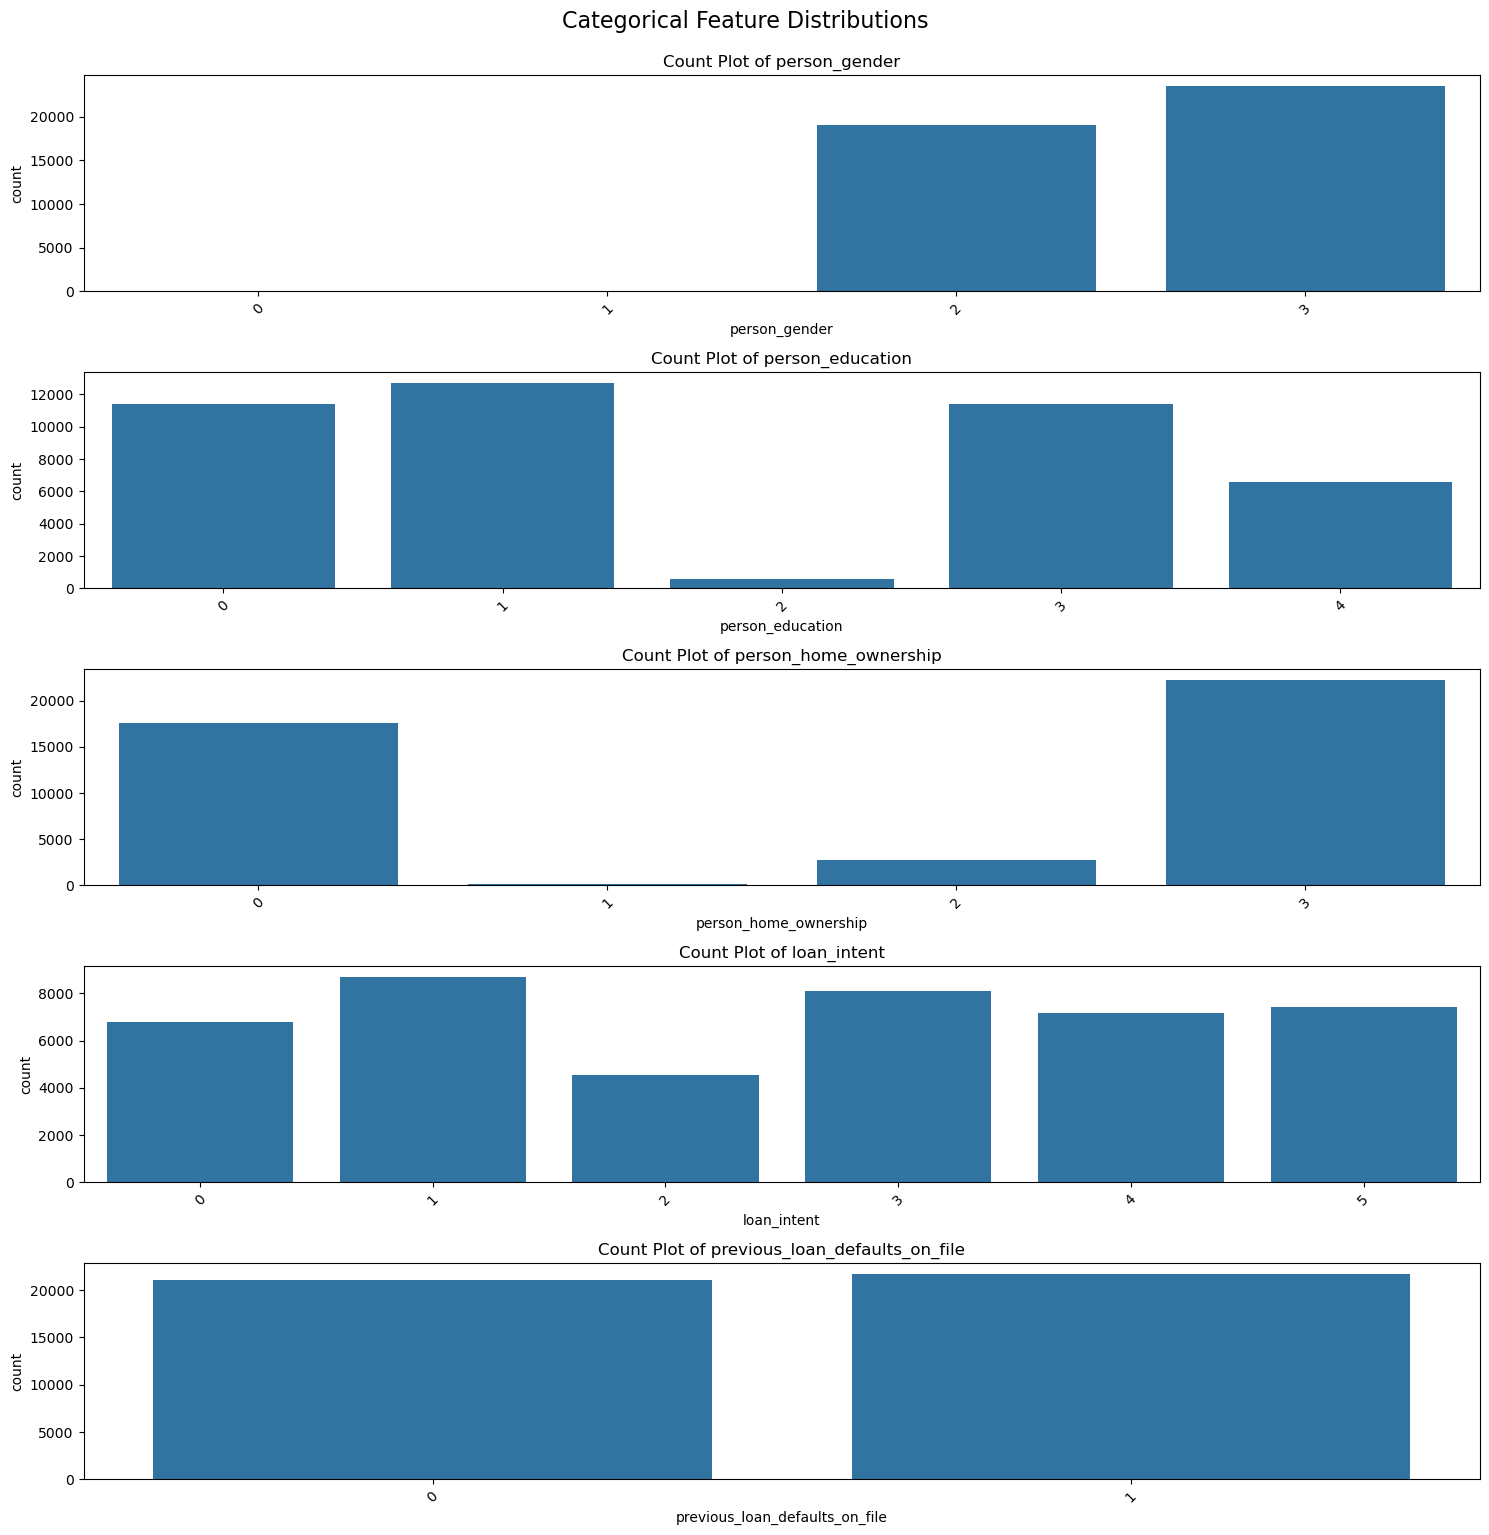


Plotting correlation matrix...


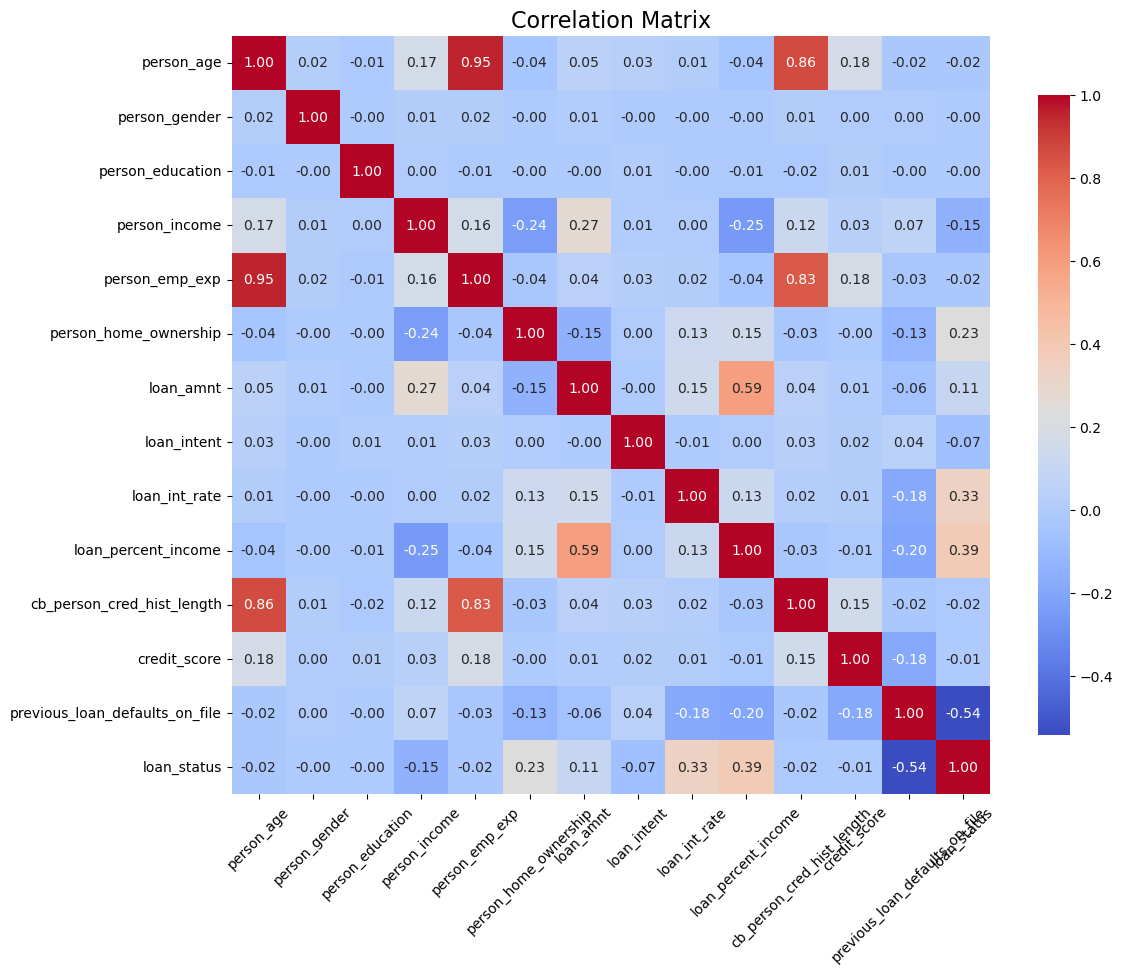

c:\Users\forti\anaconda3\envs\ML\lib\site-packages\xgboost\core.py:158: UserWarning: [14:18:38] WARNING: D:\bld\xgboost-split_1733179535861\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model training completed.

--- Evaluation Results ---
Random Forest Accuracy: 0.9263
XGBoost Accuracy     : 0.9335

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      6656
           1       0.88      0.77      0.82      1894

    accuracy                           0.93      8550
   macro avg       0.91      0.87      0.89      8550
weighted avg       0.92      0.93      0.92      8550


XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      6656
           1       0.88      0.81      0.84      1894

    accuracy                           0.93      8550
   macro avg       0.91      0.89      0.90      8550
weighted avg       0.93      0.93      0.93      8550


Best model selected: XGBoost

Best model saved as 'best_loan_model.pkl'


In [31]:
if __name__ == "__main__":
    trainer = LoanModelTrainer("Dataset_A_loan.csv")
    trainer.run()